In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [7]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/coco/images/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/coco/annotations/person_keypoints_val_782.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000397133.jpg', '000000252219.jpg', '000000296649.jpg', '000000386912.jpg', '000000143931.jpg', '000000463730.jpg', '000000233771.jpg', '000000301867.jpg', '000000356427.jpg', '000000266409.jpg', '000000430961.jpg', '000000577539.jpg', '000000349860.jpg', '000000180135.jpg', '000000400573.jpg', '000000370677.jpg', '000000180560.jpg', '000000355257.jpg', '000000239347.jpg', '000000473237.jpg', '000000078915.jpg', '000000551215.jpg', '000000544519.jpg', '000000023899.jpg', '000000057597.jpg', '000000399462.jpg', '000000326541.jpg', '000000508730.jpg', '000000368294.jpg', '000000301135.jpg', '000000356387.jpg', '000000117425.jpg', '000000048153.jpg', '000000295713.jpg', '000000273132.jpg', '000000512836.jpg', '000000562243.jpg', '000000292236.jpg', '000000500257.jpg', '000000334719.jpg', '000000283520.jpg', '000000118921.jpg', '000000172571.jpg', '000000239537.jpg', '000000537991.jpg', '000000190756.jpg', '000000361103.jpg', '000000264535.jpg', '000000458755.jpg', '000000101068.jpg',

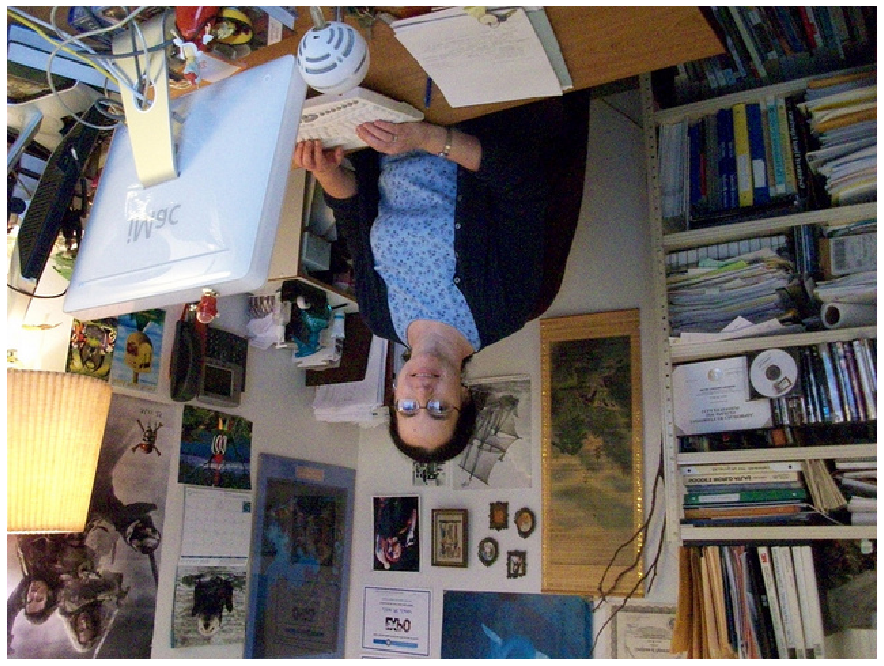

In [9]:
imshow(test_images[3])

In [7]:
s_v1 = []
s_v2 = []
s_v3 = []

c_v1 = []
c_v2 = []
c_v3 = []

u_v1 = []
u_v2 = []
u_v3 = []

In [8]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "pp"
its = range(3000,5001,1000)
its = range(1000,10001,1000)

#its = range(1000,4001,1000)
#its = range(1000,6001,1000)

losses = ["all/combined/1", "p2all/standard/1"]
loss = losses[1]

its = [5000]
for it in its:
    t = []
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'pup', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_pup/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.1,
    )


    for idx, image in enumerate(test_images):#test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        t.append(tps)
    s_v1.append(t)
        
        

5000 it
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=33, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=34, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=36, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=39, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=37, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=46, image_width=1280, image_h

FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=33, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=39, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=20, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=30, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=87, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=24, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=89, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=0, image_width=1280, image_height=720, 

FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=22, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=80, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=21, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=71, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=24, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=31, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=72, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=26, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=65, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=16, image_width=1280, image_height=720, m

FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=25, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=82, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=25, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=21, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=100, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=13, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=80, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=22, image_width=1280, image_height=720, mode=xyxy)
FIELDS:
predictions BoxList(num_boxes=70, image_width=1280, image_height=720, mode=xyxy)
top preds BoxList(num_boxes=21, image_width=1280, image_height=720, 

In [9]:
print((s_v1[0]))

[BoxList(num_boxes=33, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=34, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=36, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=39, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=37, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=46, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=36, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=38, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=37, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=29, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=41, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=44, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=41, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=39, image_width=1280, image_height=720, mode=xyxy), BoxList(num_boxes=2

In [10]:
saver = {"standard":[{'v1':s_v1}, {'v2':s_v2}, {'v3':s_v3}],
"combined":[{'v1':c_v1}, {'v2':c_v2}, {'v3':c_v3}],
"unlabeled":[{'v1':u_v1}, {'v2':u_v2}, {'v3':u_v3}]}


In [11]:
import pickle
#with open('all_135_test_boxes.pkl', 'wb') as f:
 #   pickle.dump(saver, f)


In [12]:
import pickle
with open('all_5_test_boxes.pkl', 'rb') as f:
    r5 = pickle.load(f)
print((r5['standard'][0]['v1'][0][10]))

BoxList(num_boxes=16, image_width=2560, image_height=1440, mode=xyxy)


In [13]:
from maskrcnn_benchmark.data.datasets.evaluation import evaluate
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo


config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'human', \
                     'OUTPUT_DIR', 'training_dir/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/fcos_kps_ms_training_R_50_FPN_1x_bee/mode.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

ds = make_data_loader(cfg, poop=True)

When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


train san check: True
im p gpu:  16
DATA Path;  ('pup_val_cocostyle',)
name?
/home/bsb2144/directpose/tools/datasets/pup/annotations/pup_val2.json
datasets/pup/images
PupKeypoints
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
len ids pre  178


In [14]:
res = evaluate(ds, s_v1[0], 'pathhe')[0]
ap = res.results['keypoints']['AP']
ap_50 = res.results['keypoints']['AP50']
ap_75 = res.results['keypoints']['AP75']
ap2 = res.results['keypoints']['APl']
print(ap2)

Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b48e42df438>
coco_dt <pycocotools.coco.COCO object at 0x2b48e5a833c8>
iou_type keypoints
datatype pup
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.42s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0

In [40]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "pp"
its = range(1000,6001,1000)

losses = ["all/standard/3"]
loss = losses[0]
t = []
its = [1000]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'person', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_pp/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.02,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        #plt.gca().invert_yaxis()
        #imshow(predictions[:, :, [2, 1, 0]])
        #plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']         
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                #print(p['id'])
                #bb = p["segmentation"]#p['bbox']
                bb = p['bbox']
                #bb = bb[0]
                print('bb', bb)
                bb_f = bb#[bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bb#bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_valog = p["keypoints"]
                #print('kps val', kps_val)
                # comment for test and remove og
                kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                print("kps val", kps_val)
                print("kp pl", kps_pl)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print(diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    t.append(mse_test)
    print("mse yo", mse_test)


1000 it
FIELDS:
predictions BoxList(num_boxes=100, image_width=640, image_height=427, mode=xyxy)
top preds BoxList(num_boxes=100, image_width=640, image_height=427, mode=xyxy)
397133
bb [388.66, 69.92, 109.41, 277.62]
kps val [433, 94, 434, 90, 0, 0, 443, 98, 0, 0, 420, 128, 474, 133, 396, 162, 489, 173, 0, 0, 0, 0, 419, 214, 458, 215, 411, 274, 458, 273, 402, 333, 465, 334]
kp pl [251.4544219970703, 139.54476928710938, 253.6942901611328, 135.9358673095703, 250.0334014892578, 133.36221313476562, 253.77813720703125, 136.74014282226562, 246.05096435546875, 137.05262756347656]


ValueError: operands could not be broadcast together with shapes (34,) (10,) 

12000 it
FIELDS:
predictions BoxList(num_boxes=100, image_width=480, image_height=640, mode=xyxy)
top preds BoxList(num_boxes=0, image_width=480, image_height=640, mode=xyxy)
S tensor([])
000000463730.jpg


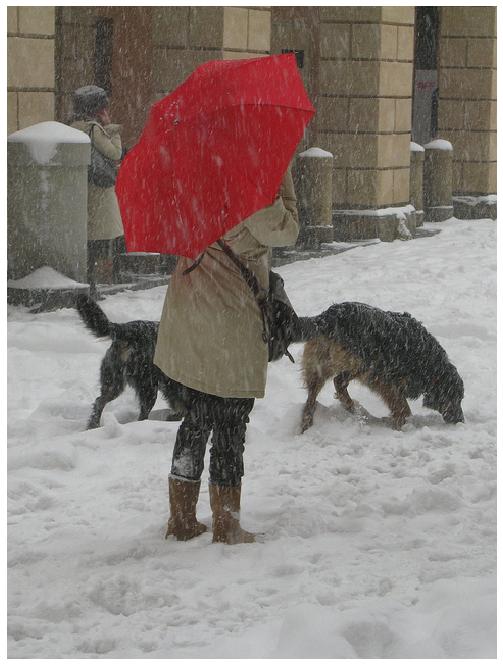

In [49]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain
checks = [46,40 ,61,3]
data_size = "pp"
its = range(1000,10001,1000)

losses = ["all/standard/3"]
t = []
i=0
loss = losses[i]
ity = [12000, 3000,1000]
its = [ity[i]]
for p in its:
    print(p,"it")
    it = p
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'person', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_pp/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[35]]
    for idx, image in enumerate(tim):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        print("S",tps.get_field('scores'))
        plt.gca().invert_yaxis()
        plt.imshow(predictions[:, :, [2, 1, 0]])
        plt.axis("off")
        plt.gca().invert_yaxis()

print(test_files[5])       